In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [23]:
df=pd.read_csv("finaldata.csv")
df.head()

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference
0,1.22.35.226,6,6.0,6,6,1.338050e+04,1.943990e+04,7.000000
1,100.2.4.116,6,3.0,6,6,1.811173e+07,2.803655e+07,1201.666667
2,100.43.83.137,84,21.0,84,56,1.505974e+04,1.469133e+04,2485.226190
3,101.119.18.35,33,33.0,33,32,7.144242e+04,1.136064e+05,1.696970
4,101.199.108.50,3,3.0,3,3,1.460800e+04,2.029127e+04,5.000000


# K-Means Clustering Algorithm

In [24]:
chosen_data = df[['Total Requests', 'Daily Mean', 'GET requests',
       'Successful requests', 'Mean Return Size', 'Return Size Std',
       'Mean Time Difference']]

In [25]:
chosen_data.head()

,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference
0,6,6.0,6,6,1.338050e+04,1.943990e+04,7.000000
1,6,3.0,6,6,1.811173e+07,2.803655e+07,1201.666667
2,84,21.0,84,56,1.505974e+04,1.469133e+04,2485.226190
3,33,33.0,33,32,7.144242e+04,1.136064e+05,1.696970
4,3,3.0,3,3,1.460800e+04,2.029127e+04,5.000000


In [26]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(chosen_data)
chosen_data = pd.DataFrame(np_scaled, columns=chosen_data.columns)

In [27]:
chosen_data.head()

,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference
0,0.010395,0.028169,0.012448,0.014286,0.000205,0.000506,0.000195
1,0.010395,0.011268,0.012448,0.014286,0.277533,0.730236,0.033394
2,0.172557,0.112676,0.174274,0.133333,0.000231,0.000383,0.069063
3,0.066528,0.180282,0.068465,0.076190,0.001095,0.002959,0.000047
4,0.004158,0.011268,0.006224,0.007143,0.000224,0.000529,0.000139


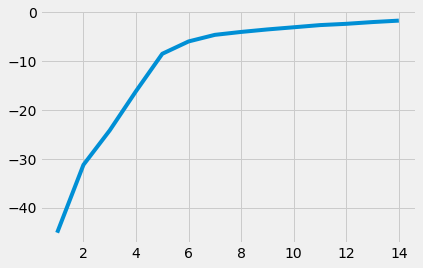

In [28]:
n_cluster = range(1, 15)
kmeans = [KMeans(n_clusters=i, random_state=42).fit(chosen_data) for i in n_cluster]
scores = [kmeans[i].score(chosen_data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [105]:
cluster_model = kmeans[4]
df['cluster'] = cluster_model.predict(chosen_data)
df['cluster'].value_counts()

0    1657
1      63
2      15
3      14
4       4
Name: cluster, dtype: int64

In [106]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500, random_state=42)
tsne_results = tsne.fit_transform(chosen_data)

In [107]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

In [108]:
tsne_cluster = df.groupby('cluster').agg({'tsne-2d-one':'mean', 'tsne-2d-two':'mean'}).reset_index()

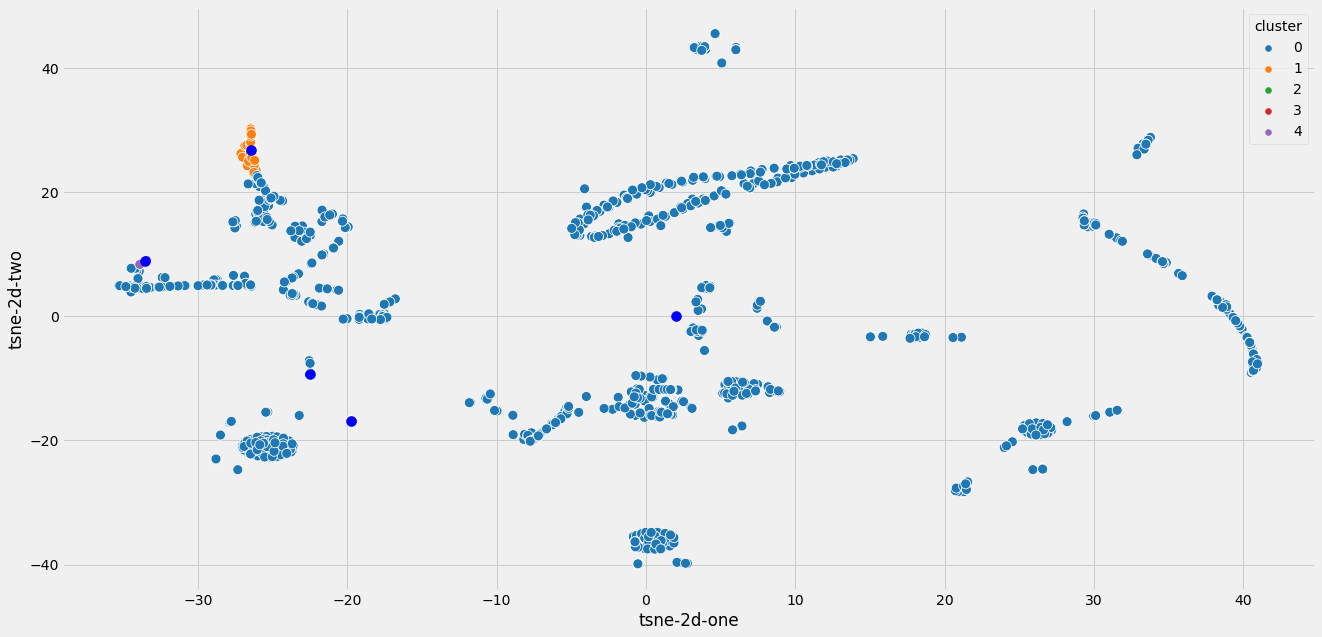

In [109]:
plt.figure(figsize=(20,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=df,
    hue="cluster",
    palette=sns.color_palette("tab10", 5),
    legend="full",
    alpha=1,
    s=100
)

plt.scatter(x="tsne-2d-one", y="tsne-2d-two", data=tsne_cluster, s=100, c='b')

plt.show()

In [110]:
centers = cluster_model.cluster_centers_
points = np.asarray(chosen_data)
total_distance = pd.Series(dtype='float64')

In [111]:
def get_sum_square_distance(data, cluster_model):
    centers = cluster_model.cluster_centers_
    points = np.asarray(data[chosen_data.columns])
    total_distance = pd.Series(dtype='float64')
    for i in range(len(points)):
        distance = 0
        for j in range(len(centers)):
            a = np.linalg.norm(points[i] - centers[j])
            # print("a = ",a)
            distance += a**2
        total_distance.at[i]= distance
        # print('distance = ',distance)
    
    return total_distance

In [112]:
df['ssd'] = get_sum_square_distance(chosen_data, cluster_model)


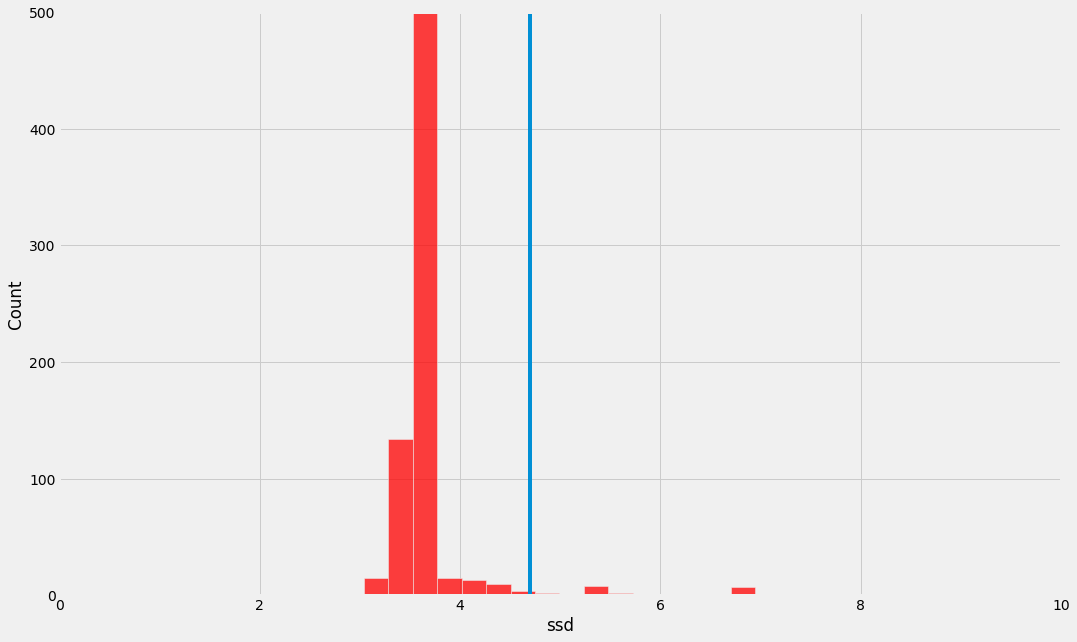

In [120]:
plt.figure(figsize=(16,10))
histo = sns.histplot(data=df,x="ssd",bins=50,color='red')
histo.set(xlim=(0,10),ylim=(0,500))
plt.axvline(4.7, 0, label="Cutoff")


In [114]:
cutoff = 4.7
df['anomaly_kmeans'] = (df['ssd'] >= cutoff).astype(int)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

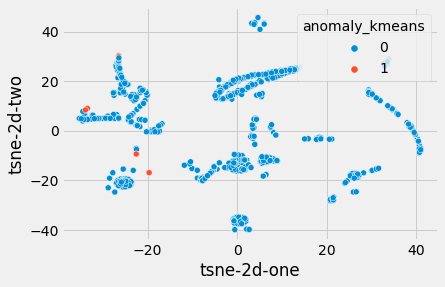

In [115]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_kmeans",
    data=df,
    legend="full",
    alpha=1
)

In [116]:
df.loc[df['anomaly_kmeans']==1].head()

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans
1,100.2.4.116,6,3.0,6,6,1.811173e+07,2.803655e+07,1201.666667,2,-22.517538,-9.183304,4.718631,1
194,130.117.119.80,3,1.5,3,3,9.316000e+03,0.000000e+00,25196.333333,1,-26.449690,30.002935,5.511994,1
202,130.237.218.86,357,178.5,357,288,1.230270e+05,3.160264e+05,202.005602,4,-33.455757,9.016716,11.718255,1
335,173.236.34.182,1,1.0,1,1,5.430675e+07,0.000000e+00,0.000000,3,-19.724281,-16.879522,5.302922,1
511,182.253.73.95,2,2.0,2,2,2.715823e+07,3.839382e+07,15.500000,2,-22.538189,-9.512394,6.816781,1


In [119]:
df.loc[df['anomaly_kmeans']==0]

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans
0,1.22.35.226,6,6.0,6,6,13380.500000,19439.904946,7.000000,0,3.135482,21.951353,3.574196,0
2,100.43.83.137,84,21.0,84,56,15059.738095,14691.328815,2485.226190,0,-34.084259,7.460135,3.182848,0
3,101.119.18.35,33,33.0,33,32,71442.424242,113606.375461,1.696970,0,-33.441013,4.527158,3.315723,0
4,101.199.108.50,3,3.0,3,3,14608.000000,20291.266422,5.000000,0,3.377113,-2.353141,3.623093,0
5,101.226.168.196,1,1.0,1,1,12292.000000,0.000000,0.000000,0,40.441734,-4.190257,3.659148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1748,99.188.185.40,1,1.0,1,1,175208.000000,0.000000,0.000000,0,-25.855734,-20.684523,3.653727,0
1749,99.237.56.116,2,2.0,2,2,26875.000000,32862.080549,7.500000,0,-6.647799,-18.128641,3.639277,0
1750,99.252.100.83,26,26.0,26,25,11466.192308,29435.485575,140.192308,0,-31.875519,4.846638,3.352515,0
1751,99.33.244.41,9,4.5,9,9,10363.555556,16002.935325,6.111111,0,7.670929,2.450920,3.557416,0


Isolated forests

In [118]:
outlier_fraction = 0.028
model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=3, random_state=42, contamination=outlier_fraction,)

TypeError: __init__() got an unexpected keyword argument 'behaviour'

In [204]:
model.fit(chosen_data)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


IsolationForest(behaviour='new', bootstrap=False, contamination=0.028,
                max_features=3, max_samples='auto', n_estimators=200, n_jobs=-1,
                random_state=42, verbose=0, warm_start=False)

In [205]:
df['anomaly_isolated'] = pd.Series(model.predict(chosen_data))

In [206]:
df['anomaly_isolated'] = df['anomaly_isolated'].map( {1: 0, -1: 1} )
df['anomaly_isolated'].value_counts()

0    403
1     12
Name: anomaly_isolated, dtype: int64

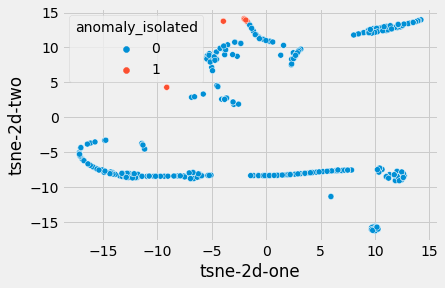

In [207]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_isolated",
    data=df,
    legend="full",
    alpha=1
)

In [208]:
df.loc[df['anomaly_isolated']==1]

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans,anomaly_isolated
50,157.55.39.17,47,47.0,47,46,2.907660e+03,4.854550e+03,1638.521739,2,-1.831992,13.868539,4.566288,0,1
51,157.55.39.26,58,29.0,58,54,4.883121e+03,6.573502e+03,1149.719298,2,-1.736940,13.663938,4.496382,0,1
54,157.55.39.75,64,64.0,64,63,3.828141e+03,4.227239e+03,998.000000,2,-2.040431,14.133765,4.804857,0,1
125,195.191.163.28,7,7.0,7,6,7.846000e+07,2.075582e+08,661.166667,4,-9.146929,4.303019,8.750140,1,1
136,220.158.157.182,9,9.0,9,4,6.080910e+07,1.824047e+08,17.875000,4,-9.145062,4.293844,7.727056,1,1
139,27.65.252.148,6,6.0,6,5,9.153451e+07,2.241887e+08,13.400000,4,-9.151245,4.291281,9.567791,1,1
154,40.77.167.35,43,43.0,43,41,2.817860e+03,3.322268e+03,1737.928571,2,-1.757976,13.738455,4.555790,0,1
156,40.77.167.38,76,38.0,76,75,3.680197e+03,4.693449e+03,978.480000,2,-1.984128,14.029704,4.584959,0,1
159,40.77.167.97,50,50.0,50,47,3.703060e+03,4.927921e+03,1221.061224,2,-1.875208,13.933555,4.599638,0,1
227,54.36.148.17,292,146.0,292,292,1.292700e+04,1.491498e+04,306.278351,3,-3.936702,13.761462,19.941191,1,1


One Class SVM

In [209]:
model1 =  OneClassSVM(nu=outlier_fraction, degree=2, kernel='rbf')

In [210]:
data_new_clean = chosen_data.loc[chosen_data['Total Requests'] <=chosen_data['Total Requests'].quantile(1-outlier_fraction)]

In [211]:
model1.fit(data_new_clean)

OneClassSVM(cache_size=200, coef0=0.0, degree=2, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.028, shrinking=True, tol=0.001, verbose=False)

In [212]:
df['anomaly_svm'] = pd.Series(model.predict(chosen_data))

In [213]:
df['anomaly_svm'] = df['anomaly_svm'].map( {1: 0, -1: 1} )
df['anomaly_svm'].value_counts()

0    403
1     12
Name: anomaly_svm, dtype: int64

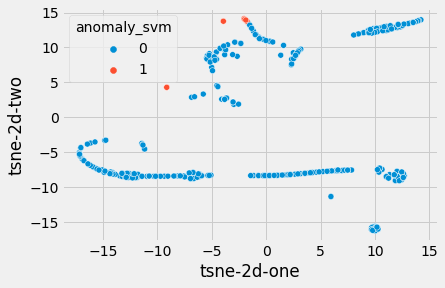

In [214]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_svm",
    data=df,
    legend="full",
    alpha=1
)

In [215]:
df.loc[df['anomaly_svm']==1]

,IP,Total Requests,Daily Mean,GET requests,Successful requests,Mean Return Size,Return Size Std,Mean Time Difference,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans,anomaly_isolated,anomaly_svm
50,157.55.39.17,47,47.0,47,46,2.907660e+03,4.854550e+03,1638.521739,2,-1.831992,13.868539,4.566288,0,1,1
51,157.55.39.26,58,29.0,58,54,4.883121e+03,6.573502e+03,1149.719298,2,-1.736940,13.663938,4.496382,0,1,1
54,157.55.39.75,64,64.0,64,63,3.828141e+03,4.227239e+03,998.000000,2,-2.040431,14.133765,4.804857,0,1,1
125,195.191.163.28,7,7.0,7,6,7.846000e+07,2.075582e+08,661.166667,4,-9.146929,4.303019,8.750140,1,1,1
136,220.158.157.182,9,9.0,9,4,6.080910e+07,1.824047e+08,17.875000,4,-9.145062,4.293844,7.727056,1,1,1
139,27.65.252.148,6,6.0,6,5,9.153451e+07,2.241887e+08,13.400000,4,-9.151245,4.291281,9.567791,1,1,1
154,40.77.167.35,43,43.0,43,41,2.817860e+03,3.322268e+03,1737.928571,2,-1.757976,13.738455,4.555790,0,1,1
156,40.77.167.38,76,38.0,76,75,3.680197e+03,4.693449e+03,978.480000,2,-1.984128,14.029704,4.584959,0,1,1
159,40.77.167.97,50,50.0,50,47,3.703060e+03,4.927921e+03,1221.061224,2,-1.875208,13.933555,4.599638,0,1,1
227,54.36.148.17,292,146.0,292,292,1.292700e+04,1.491498e+04,306.278351,3,-3.936702,13.761462,19.941191,1,1,1
